In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf

In [4]:
from wgomoku import (
    GomokuTools as gt, SampleDataHelper, GomokuBoard, Heuristics,
    PolicyModel, ValueModel, TerminalDetector, display_sample, 
    A2C_SampleGeneratorFactory, analyse_and_recommend, SelfPlay)

In [5]:
N=19

---
# Load the Policy and Value Models

In [55]:
#latest_policy_model = tf.train.latest_checkpoint("./models/PolicyNet_1.0/")
policy_model = PolicyModel(board_size=19, n_blocks=10, 
                    n_layers=3, n_filters=32, 
                    activation='relu')
policy_model.load_weights("./models/PolicyNet_1.0/cp-0003.ckpt")

./models/PolicyNet_1.0/cp-0006.ckpt


In [57]:
#latest_value_model = tf.train.latest_checkpoint("./models/ValueNet_3.0/")
value_model = ValueModel(19, 10, 3, 32, 'relu')
value_model.load_weights("./models/ValueNet_3.0/cp-0001.ckpt")

---
### Potential issues
#### Frustration
Incoming gradients from the losing side may increase the entropy such that the policy essentially creates a uniform distribution. 

Frustration may arise from the *critic* not being consistent yet. It's definitely worth looking at the quality of the *critic*'s advantages. On any single trajectory, the perfect critic would match the alernating bellmann scheme.

Frustration will most likely arise from the alternating scheme in general, as negative and positive signals are evenly distributed. 

It would be interesting to report the entropy as a metric.

One quick win could come from switching off the losing signal totally

#### Off-by-one
We still have that mysterious off-by-one problem in function ```analyse_and_recommend```.
We need to understand what it is to rule out that despite the hack, it still provides a wrong recommendation.


---
### Self-Play with a well-known threat-sequence
From Victoria vs Xokk we have a nice episode:

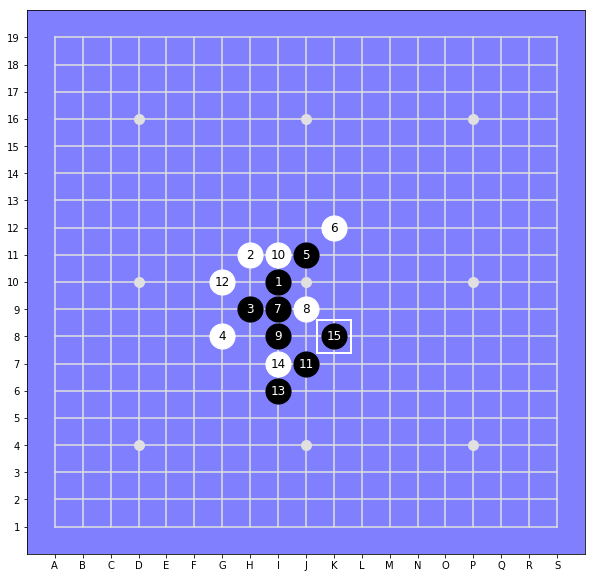

In [58]:
v_vs_x = 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8' #'l9j8l8l6k7k6l5'
stones = gt.string_to_stones(v_vs_x)
heuristics = Heuristics(kappa=3.0)
board = GomokuBoard(disp_width=10, N=19, heuristics= heuristics, stones = stones)
board.display()

In [59]:
sdh = SampleDataHelper(N=19, edges=True, representation='NxNx1B')

In [60]:
trajectory = [gt.b2m((r, c), 19)+[1,1] for (r, c) in board.stones]
trajectory

[array([10,  9]),
 array([9, 8]),
 array([11,  8]),
 array([12,  7]),
 array([ 9, 10]),
 array([ 8, 11]),
 array([11,  9]),
 array([11, 10]),
 array([12,  9]),
 array([9, 9]),
 array([13, 10]),
 array([10,  7]),
 array([14,  9]),
 array([13,  9]),
 array([12, 11])]

In [61]:
smp = sdh.create_sample(trajectory, 1)

In [62]:
display_sample(smp)

[[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  1  1 -1  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  1  0 -1  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0 -1 -1  1  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  1  0 -1  0 -1  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0

In [63]:
sp = SelfPlay(policy=policy_model, board_size=19, start_with=trajectory)

You can create a single episode. The ```traj``` return value is the trajectory, also referred to as *stones* or *moves*. They come in board coordinates

In [80]:
game, traj, terminated = sp.create_episode(
    limit=50, n_choices=10, greedy_bias=300, m2b='board')

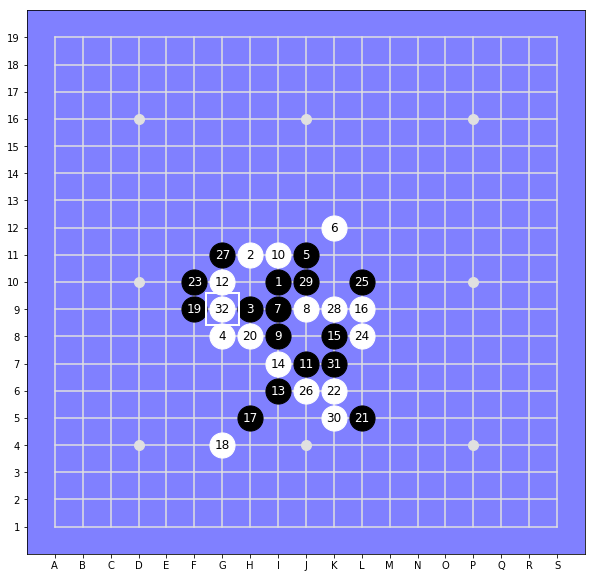

In [81]:
board = GomokuBoard(N=19, heuristics=Heuristics(kappa=3.0), stones=traj, 
                    disp_width=10)
board.display()